# Lab 4: Building a Spotify Song Classifier with KNNs and Decision Trees
**Classify by genres**. In this lab, you will build machine learning genre classifiers using a dataset of Spotify tracks. Your goal is to train a model that can distinguish between two selected genres based on various audio features such as danceability, energy, valence, tempo, and more.

We'll follow the familiar workflow of data exploration -> preprocessing -> model training -> evaluation

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np

### Step 1: The data
We'll focus on two genres: Blues and Jazz (what’s the difference, anyway??).

Both genres have rich musical histories, but they differ in structure:

- Blues tends to have simpler chord progressions and a strong emotional expression.
- Jazz often involves complex improvisation and more varied rhythms.

But can a machine really tell them apart just by looking at numerical audio features? That’s what we’ll find out!

In this step, you will:
- Load the dataset
- Extract only blues and jazz for classification

In [2]:
spotify_data = pd.read_csv('/courses/EDS232/Data/spotify_dat.csv')

# Print the data types in spotify_data
print(spotify_data.dtypes)

id                   object
name                 object
album                object
album_id             object
artists              object
artist_ids           object
track_number          int64
disc_number           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature      float64
year                  int64
release_date         object
genres               object
dtype: object


In [3]:
print(spotify_data["genres"].unique())

['rap metal' 'soft rock' 'Unknown' 'singer-songwriter' 'americana'
 'christian rock' 'skate punk' 'pop punk' 'new wave' 'country'
 'madchester' 'j-rock' 'blues' 'grime' 'art rock' 'blues rock'
 'chamber pop' 'french jazz' 'worship' 'ccm' 'alternative rock'
 'indie rock' 'new age' 'classic rock' 'bluegrass' 'traditional country'
 'classical piano' 'folk' 'chamber music' 'classical' 'minimalism'
 'southern rock' 'roots rock' 'mariachi' 'nu jazz' 'breakcore'
 'avant-garde' 'arabic rap' 'grunge' 'progressive rock' 'punk'
 'post-hardcore' 'noise rock' 'sludge metal' 'nu metal' 'metal'
 'industrial metal' 'hardcore' 'orchestra' 'latin jazz' 'dream pop'
 'garage rock' 'trip hop' 'post-grunge' 'britpop' 'big beat' 'idm'
 'rock en español' 'mexican ska' 'minimal techno' 'chanson'
 'alternative dance' 'drone' 'proto-punk' 'gospel' 'indie folk'
 'hardcore punk' 'neue deutsche welle' 'space music' 'r&b' 'latin pop'
 'christmas' 'emo' 'power pop' 'chillstep' 'salsa' 'spoken word'
 'west coast hip h

In [4]:
# Filter down to two genres
blues_data = spotify_data[spotify_data["genres"] == "blues"]

#print(blues_data["genres"].unique())
#print(blues_data.head())

jazz_data = spotify_data[spotify_data["genres"] == "jazz"]

print(jazz_data["genres"].unique())

print(jazz_data.head())


['jazz']
                          id                    name       album  \
9370  2gUvAgzcah09iRarSf62fN       Everything I Love  Blue Waltz   
9371  5BWzVgoB7GF0GoPleZwlg0              Blue Waltz  Blue Waltz   
9372  16EJtLHY51K46GULZjrSUc      Come Rose Dai Muri  Blue Waltz   
9373  4THJKQ6mYTL7fuvcwcrcOy            Molto Ancora  Blue Waltz   
9374  6XmyMmdKUgzC66oHOgPnSk  All the Things You Are  Blue Waltz   

                    album_id                                    artists  \
9370  4ieAxUV4WFZj9imsPVehYa  ['Enrico Pieranunzi', 'Thomas Fonnesbæk']   
9371  4ieAxUV4WFZj9imsPVehYa  ['Enrico Pieranunzi', 'Thomas Fonnesbæk']   
9372  4ieAxUV4WFZj9imsPVehYa  ['Enrico Pieranunzi', 'Thomas Fonnesbæk']   
9373  4ieAxUV4WFZj9imsPVehYa  ['Enrico Pieranunzi', 'Thomas Fonnesbæk']   
9374  4ieAxUV4WFZj9imsPVehYa  ['Enrico Pieranunzi', 'Thomas Fonnesbæk']   

                                             artist_ids  track_number  \
9370  ['5vACdMa2kY7jHnlJwqYRKP', '2GWMZZQNuU0VZra0su...   

In [5]:
# Combine both genres into one dataset
combined_data = pd.concat([blues_data, jazz_data], ignore_index = True)

# Check to ensure concat was sucessful
print(combined_data['genres'].unique())

['blues' 'jazz']


In [6]:
# Rename 'genres' column to 'genre' for clarity
combined_data = combined_data.rename(columns = {'genres' : 'genre'})

print(combined_data['genre'].head())

0    blues
1    blues
2    blues
3    blues
4    blues
Name: genre, dtype: object


## Step 2: Data Exploration
Now that we have Blues and Jazz as our two genres, it's time to explore the data and look for patterns in the audio features.

Let's investigate:
- Which features are available?
- How strongly these features correlate with each other.
- How different genres distribute across  sample features: danceability 

In this step, we will:
- Filter out non-numeric columns before the plotting
- Visualize feature correlations using a heatmap.
- Examine key feature distributions with histograms to see if genres behave differently.


track_number          int64
disc_number           int64
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature      float64
year                  int64
genre                object
dtype: object


/opt/python/3.7.13/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


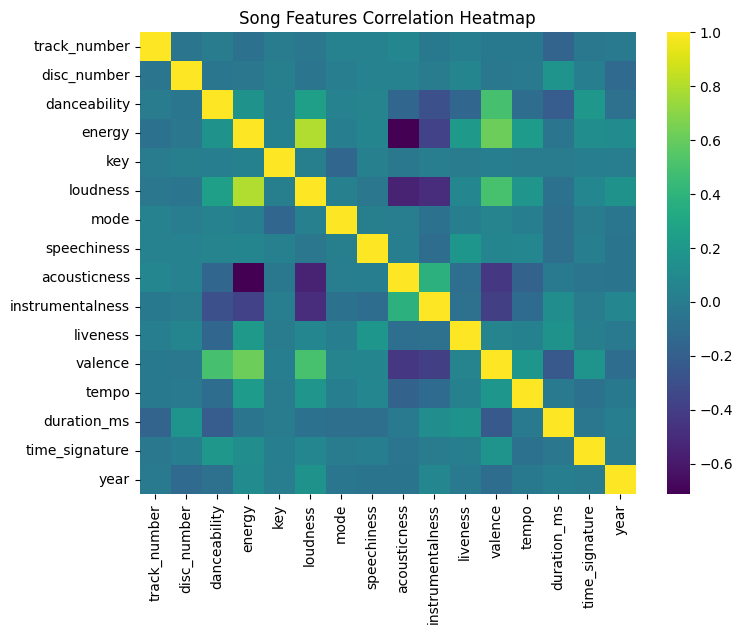

In [7]:
# Exclude non-numeric columns but keep 'genre' for grouping
numeric_features = combined_data.select_dtypes(include='number')
numeric_features['genre'] = combined_data['genre']

print(numeric_features.dtypes)

#Correlation heatmap
corr = numeric_features.corr()

# Generate a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=False, cmap = 'viridis')
plt.title("Song Features Correlation Heatmap")

plt.show()

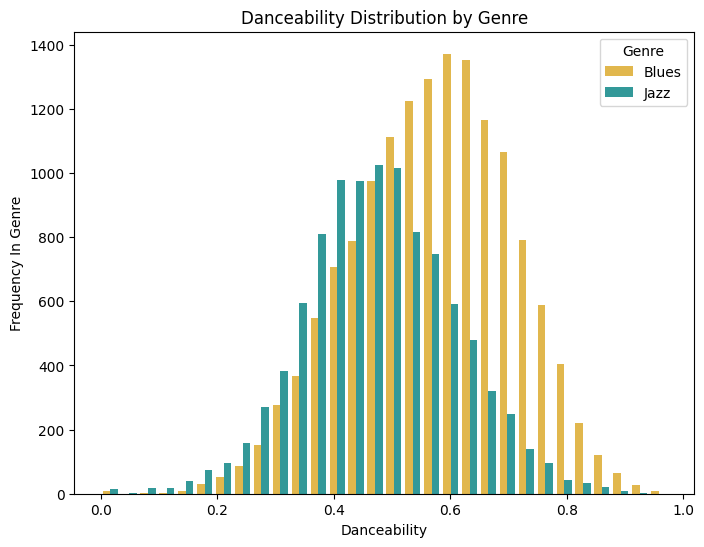

In [8]:
# Histogram of danceability
plt.figure(figsize=(8, 6))
plt.hist([combined_data[combined_data['genre'] == 'blues']['danceability'], 
          combined_data[combined_data['genre'] == 'jazz']['danceability']], 
         bins=30, alpha=0.8, label=['Blues', 'Jazz'], color=['goldenrod', 'teal'])
plt.xlabel('Danceability')
plt.ylabel('Frequency In Genre')
plt.title('Danceability Distribution by Genre')
plt.legend(title='Genre')
plt.show()

### Step 3: Check for class imbalance
An unequal distribution between the target classes can cause issues for our classifiers, so we'll need to check for that. A commonly used guideline for class imbalance is:

- Slight Imbalance (Less than 1.5:1) → Generally okay; no need for balancing.
- Moderate Imbalance (Between 1.5:1 and 3:1) → Might cause some bias; balancing can help.
- Severe Imbalance (More than 3:1) → Strongly affects model performance; balancing is usually necessary.

In [9]:
# Print counts of each genre
class_counts = combined_data['genre'].value_counts()

# Calculate ratio of majority to minority class
class_ratio = class_counts.max() / class_counts.min()

# Print class distribution and ratio
print("Class distribution:\n",class_counts)
print(f"Class ratio:\n{class_ratio:.3f}:1")

Class distribution:
 blues    14811
jazz     10023
Name: genre, dtype: int64
Class ratio:
1.478:1


**Question:**

Given this result, should we be worried about the imbalance?

**Answer:**

Because our class imbalance is 1.48:1, I am not worried about the class imbalance based on the scale above. Our score implies that in general we are okay and we do not need to balance.

### Step 4: Preprocessing
We need to ensure all the variables we use are numerical so the models can process them. First we'll drop all the variables that are not numeric or the target. Then we'll use a sklearn utility, `LabelEncoder()` to encode our categorical target variable into numerical values. Print the first five values of your encoded labels.

In [10]:
# Define the features (drop columns that are not numeric or target)
X = combined_data.select_dtypes(include=['number']).drop(columns=['track_number', 'disc_number', 'year'])

# Set the target variable as 'genre'
y = combined_data['genre']

# Encode the target variable ('label') using label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Print first five values of encoded labels
print("Encoded labels:", y_encoded[:5])

# Printing more encoded labels to ensure there are 1s and 0s
print("Encoded labels:", y_encoded)

Encoded labels: [0 0 0 0 0]
Encoded labels: [0 0 0 ... 1 1 1]


Good, now we'll do our data splitting and scaling.  Let's go with an 80/20 split this time.

In [11]:
# Split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform only the training set
X_train_scaled = scaler.fit_transform(X_train)

# Use the same scaler to transform the test set
X_test_scaled = scaler.fit_transform(X_test) 

# Print to view X_test_scaled
print(X_test_scaled)

[[ 1.52975017 -1.6088679  -0.32113297 ... -1.38525092 -0.78735628
   0.39206564]
 [-0.19608059  0.51082402  1.10685939 ... -0.33880876  0.54848058
  -1.41441862]
 [-0.37998058 -1.58553983  1.10685939 ... -0.27588405 -0.27950979
   0.39206564]
 ...
 [ 1.0629271   0.83899866 -0.0355345  ... -0.28263175 -1.10532242
   0.39206564]
 [ 0.68805402 -1.09051012 -1.46352686 ... -0.70847934 -0.70366533
  -1.41441862]
 [-0.20315366 -0.15343311  0.82126092 ...  0.70679396  0.10160362
   0.39206564]]


### Step 5: Train the models
OK, now it's time to build our models and assess the training accuracy. We'll use the default of k = 5 for the KNN model.

In [12]:
# Initialize models
knn = KNeighborsClassifier(n_neighbors = 5)
dt = DecisionTreeClassifier(random_state = 42)

# Fit both models
knn.fit(X_train_scaled, y_train)
dt.fit(X_train_scaled, y_train)

# Predictions on training data
knn_y_train_pred = knn.predict(X_train_scaled)
dt_y_train_pred = dt.predict(X_train_scaled)

# Compute training accuracy
knn_train_accuracy = accuracy_score(y_train, knn_y_train_pred)
dt_train_accuracy = accuracy_score(y_train, dt_y_train_pred)

# Print training accuracy for both models
print("Training Accuracy:")
print(f"KNN trainingcuracy: {knn_train_accuracy:.3}")
print(f"DT training accrcay: {dt_train_accuracy:.3}")

Training Accuracy:
KNN trainingcuracy: 0.915
DT training accrcay: 1.0


### Step 6: Evaluate models
OK, now let's go ahead and predict on the test data to see how well our models do at predicting the genre of unseen tracks.

In [13]:
# Make predictions
knn_pred = knn.predict(X_test_scaled)
dt_pred = dt.predict(X_test_scaled)

# Evaluate prediction accuracy
knn_accuracy = accuracy_score(y_test, knn_pred)
dt_accuracy = accuracy_score(y_test, dt_pred)

# Print prediction accuracy for both models
print("Predictions:")
print(f"KNN accuracy prediction: {knn_accuracy:.3f}")
print(f"DT accuracy prediction: {dt_accuracy:.3f}")

Predictions:
KNN accuracy prediction: 0.877
DT accuracy prediction: 0.841


### Step 7: Visualizing Model Performance
Now that we have evaluated our models on unseen data, let’s compare their performance by visualizing the training vs. test accuracy.  We'll look for signs of overfitting by plotting the training accuracy and test accuracy for both k-NN and Decision Trees.

Create a bar chart that compares the training accuracy and test accuracy for k-NN and Decision Trees. Your plot should clearly display:

- The training and test accuracy for both models.
- Properly labeled axes and a title.
- A legend to differentiate training and test accuracy.
- Accuracy values displayed on top of each bar.

[0.9145819701011728, 1.0]
[0.876988121602577, 0.8407489430239581]


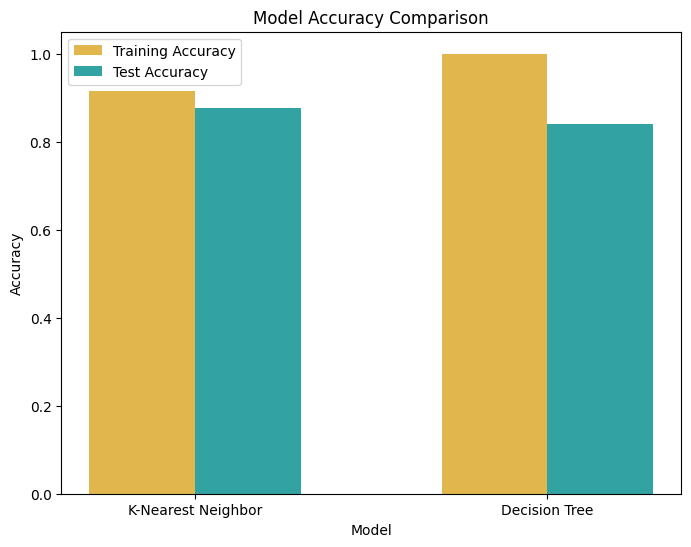

In [14]:
# Create visualization:
labels = ['K-Nearest Neighbor', 'Decision Tree']
test_accuracies = [knn_accuracy, dt_accuracy]
train_accuracies = [knn_train_accuracy, dt_train_accuracy]
N = len(labels)
ind = np.arange(N)

# Test to view accuracy values for train and test
print(train_accuracies)
print(test_accuracies)

# Figure size
plt.figure(figsize=(8, 6))
width = 0.3       

# Plotting
plt.bar(ind, train_accuracies, width, label='Training Accuracy', color='goldenrod', alpha=0.8)
plt.bar(ind + width, test_accuracies, width, label='Test Accuracy', color='darkcyan', alpha=0.8)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(ind + width / 2, labels)
plt.legend()

# print plot
plt.show()

**Question:**

Which model does a better job of generalizing to unseen data? How do you know?
Does it appear that either of the models are overfitting? Why?

In [15]:
# Model Comparison if-else
if knn_accuracy > dt_accuracy:
    acur = "KNN"
else:
    acur = "Decision Tree"

print(f"The model with the higher accuracy score is: {acur}")

# KNN Accuracy Analysis
knn_dif = knn_train_accuracy - knn_accuracy
print(f"The KNN training accuracy score is: {knn_train_accuracy:.3f}")
print(f"The KNN test accuracy score is: {knn_accuracy:.3f}")
print(f"The difference between KNN training and test accuracy is: {knn_dif:.3f}")

if knn_train_accuracy > knn_accuracy:
    print("The KNN training accuracy is higher than the testing accuracy, indicating potential overfitting.")
else:
    print("The KNN test accuracy is higher than or equal to the training accuracy.")

# Decision Tree Accuracy Analysis
dt_dif = dt_train_accuracy - dt_accuracy
print(f"\nThe Decision Tree training accuracy score is: {dt_train_accuracy:.2f}")
print(f"The Decision Tree testing accuracy score is: {dt_accuracy:.2f}")
print(f"The difference between Decision Tree training and testing accuracy is: {dt_dif:.2f}")

if dt_train_accuracy > dt_accuracy:
    print("The Decision Tree training accuracy is higher than the test accuracy, indicating potential overfitting.")
else:
    print("The Decision Tree test accuracy is higher than or equal to the training accuracy.")


The model with the higher accuracy score is: KNN
The KNN training accuracy score is: 0.915
The KNN test accuracy score is: 0.877
The difference between KNN training and test accuracy is: 0.038
The KNN training accuracy is higher than the testing accuracy, indicating potential overfitting.

The Decision Tree training accuracy score is: 1.00
The Decision Tree testing accuracy score is: 0.84
The difference between Decision Tree training and testing accuracy is: 0.16
The Decision Tree training accuracy is higher than the test accuracy, indicating potential overfitting.


**Answer:**

I would say the KNN model does better with the unseen data because the accuracy score is 0.877 vs the Decision tree model accuracy which is 0.84. The difference between the KNN training and test accuracy value (0.038) is also much smaller than the difference for the Decision Tree (0.16). While when considering models it is important to look at more than just accuracy, but for this assignment that is what we focused on so basing it on accuracy alone the KNN model does better. There also seems to be a significant amount of overfitting in the Decision Tree model, with the train accuracy score being 1.0. This would indicate severe overfitting. While the KNN training accuracy score is also high, it is not as high as the Decision tree model and has less of a difference between the testing and training scores.

### Bonus question

In the workflow above, we used the default parameter values of `k = 5` for the KNN model, and `maxdepth = None` for the Decision Tree.  Choose one of the models and see if you can improve test performance by optmizing its corresponding parameter value.